# Telco Customer Churn - Modeling


### 01. Import Libraries 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

### 02. Load Processed Data

In [4]:
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Seperate features and target
target = 'Churn'
X_train_ber_res = train_df.drop(target, axis=1)
y_train_ber_res = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

Train shape: (5634, 50)
Test shape: (1409, 50)


In [5]:
# --- Input/Output Data Inspection ---
print("Shape of Training Features (X_train_ber_res):", X_train_ber_res.shape)
print("Shape of Training Target (y_train_ber_res):", y_train_ber_res.shape)
print("Shape of Test Features (X_test):", X_test.shape)
print("Shape of Test Target (y_test):", y_test.shape)

print("\nFirst 5 rows of Input Features:")
display(X_train_ber_res.head())

print("\nFirst 5 rows of Target Labels (0 = No Churn, 1 = Churn):")
display(y_train_ber_res.head())

Shape of Training Features (X_train_ber_res): (5634, 49)
Shape of Training Target (y_train_ber_res): (5634,)
Shape of Test Features (X_test): (1409, 49)
Shape of Test Target (y_test): (1409,)

First 5 rows of Input Features:


,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureCategory_Established,TenureCategory_Loyal,TenureCategory_New
0,0.102371,-0.521976,-0.262257,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,-0.711743,0.337478,-0.503635,0,1,1,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
2,-0.793155,-0.809013,-0.749883,0,1,1,0,0,1,0,...,1,1,0,0,0,0,1,1,0,0
3,-0.263980,0.284384,-0.172722,1,0,1,0,0,1,1,...,1,0,1,0,1,0,0,1,0,0
4,-1.281624,-0.676279,-0.989374,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1



First 5 rows of Target Labels (0 = No Churn, 1 = Churn):


0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

### 03. Class Imbalance Handling 
Applied **SMOTE** once to the training set to create a balanced dataset for all models

Original Class Distribution: Counter({0: 4139, 1: 1495})
Resampled Class Distribution: Counter({0: 4139, 1: 4139})


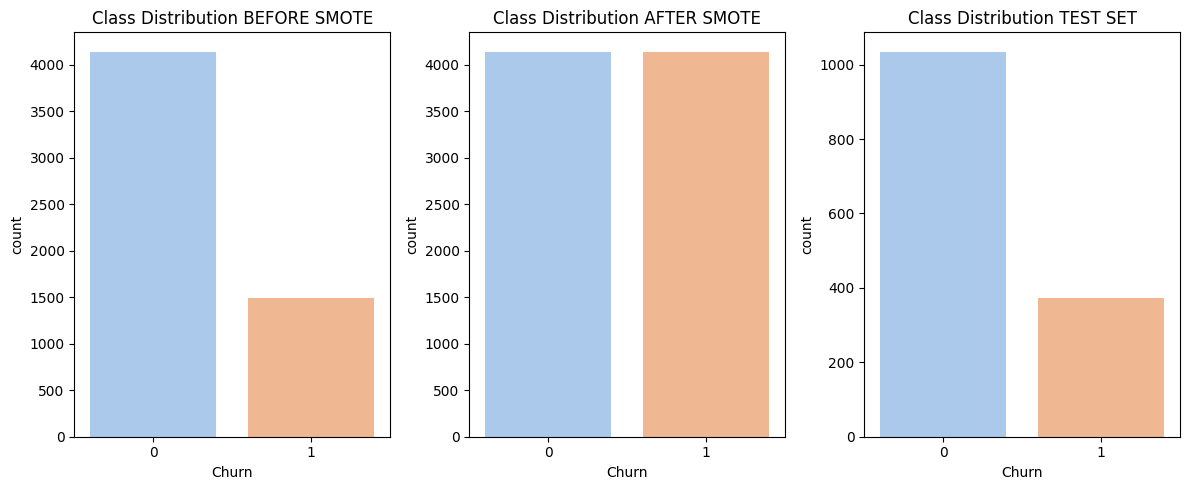

In [6]:
print("Original Class Distribution:", Counter(y_train_ber_res))

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train_ber_res, y_train_ber_res)

print("Resampled Class Distribution:", Counter(y_train))

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=y_train_ber_res, palette='pastel')
plt.title('Class Distribution BEFORE SMOTE')
plt.subplot(1, 3, 2)
sns.countplot(x=y_train, palette='pastel')
plt.title('Class Distribution AFTER SMOTE')
plt.subplot(1, 3, 3)
sns.countplot(x=y_test, palette='pastel')
plt.title('Class Distribution TEST SET')
plt.tight_layout()
plt.savefig('../artifacts/images/smote_class_distribution.png')
plt.show()

### 04. Model Development

- logistic regression
- decision tree
- random forest
- XGBoost
- CatBoost


In [8]:
models = { 
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'RandomForest' : RandomForestClassifier(),
    'XGBoost' : XGBClassifier(),
    'CatBoost' : CatBoostClassifier(),
}

# Use the Decision Tree instance to get the cost-complexity pruning path
DTpath = models['Decision Tree'].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = DTpath.ccp_alphas[DTpath.ccp_alphas >= 0]

params = {
    'Logistic Regression' : {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse regularization strength
            'solver': ['liblinear', 'saga', 'lbfgs'], # liblinear for L1, saga for elasticnet
            'max_iter': [100, 200, 500]
        },
    'Decision Tree' : {
            'ccp_alpha': list(ccp_alphas[::20]),
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        },
    'RandomForest' : {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        },
    'XGBoost' : {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2]
        },
    'CatBoost' : {
            'iterations': [100, 500, 1000],
            'learning_rate': [0.01, 0.05, 0.1],
            'depth': [4, 6, 8, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'border_count': [32, 64, 128]
        }
}

In [9]:
results = {}
best_models = {}

print("Training and Tuning Classification Models...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    print(f"\nProcessing {name}...")
    
        
    # K-Fold CV (Baseline)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"  Baseline CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # GridSearchCV
    if params[name]:
        print(f"  Tuning {name}...")
        grid = GridSearchCV(model, params[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"  Best Params: {grid.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        
    best_models[name] = best_model
    
    # Evaluate on Test Set
    preds = best_model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    
    results[name] = {
        'CV Mean Accuracy': cv_scores.mean(),
        'Test Accuracy': acc, 
        'Test F1-Score': f1
    }
    print(f"  Test Accuracy: {acc:.4f}, Test F1-Score: {f1:.4f}")

Training and Tuning Classification Models...

Processing Logistic Regression...
  Baseline CV Accuracy: 0.8506 (+/- 0.0089)
  Tuning Logistic Regression...
  Best Params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
  Test Accuracy: 0.7757, Test F1-Score: 0.7804

Processing Decision Tree...
  Baseline CV Accuracy: 0.7931 (+/- 0.0067)
  Tuning Decision Tree...
  Best Params: {'ccp_alpha': np.float64(0.0004080529258828139), 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Test Accuracy: 0.7495, Test F1-Score: 0.7584

Processing RandomForest...
  Baseline CV Accuracy: 0.8629 (+/- 0.0082)
  Tuning RandomForest...
  Best Params: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
  Test Accuracy: 0.7665, Test F1-Score: 0.7647

Processing XGBoost...
  Baseline CV Accuracy: 0.8521 (+/- 0.0059)
  Tuning XGBoost...
  Best Params: {'colsample_bytree': 0.6, 'gamma': 